In [13]:
import os

os.environ['SM_HOSTS']='1'
os.environ['SM_CURRENT_HOST']='localhost'
os.environ['SM_MODEL_DIR']='./model'
os.environ['SM_CHANNEL_TRAIN']='./data-tfrecord/bert-train'
os.environ['SM_CHANNEL_VALIDATION']='./data-tfrecord/bert-validation'
os.environ['SM_CHANNEL_TEST']='./data-tfrecord/bert-test'
os.environ['SM_OUTPUT_DIR']='./output/'
os.environ['SM_OUTPUT_DATA_DIR']='./output/data/'
os.environ['SM_NUM_GPUS']='0'
os.environ['SAGEMAKER_JOB_NAME']='JOB_NAME'
os.environ['SM_TRAINING_ENV']='{\"is_master\":true}'

# Develop Model Training Code In Noteboook

In [14]:
train_data='./input/data/train'
validation_data='./input/data/validation'
test_data='./input/data/test'

output_dir='./output/'
output_data_dir='./output/data/'
local_model_dir='./model/'

train_steps_per_epoch=1
epochs=1
learning_rate=0.00003
epsilon=0.00000001
train_batch_size=8
validation_batch_size=8
test_batch_size=8
validation_steps=1
test_steps=1
use_xla=True
use_amp=True
max_seq_length=64
freeze_bert_layer=True
run_validation=True
run_test=True
run_sample_predictions=True

hosts=1
current_host='localhost'
num_gpus=0
enable_sagemaker_debugger=False
is_master=True
pipe_mode=False

## Imports

In [15]:
import easydict

Environment Variables:
{'AWS_AUTO_SCALING_HOME': '/opt/aws/apitools/as',
 'AWS_CLOUDWATCH_HOME': '/opt/aws/apitools/mon',
 'AWS_ELB_HOME': '/opt/aws/apitools/elb',
 'AWS_PATH': '/opt/aws',
 'BASH_FUNC_module()': '() '
                       '{  '
                       'eval '
                       '`/usr/bin/modulecmd '
                       'bash '
                       '$*`\n'
                       '}',
 'CLICOLOR': '1',
 'CONDA_DEFAULT_ENV': 'python3',
 'CONDA_EXE': '/home/ec2-user/anaconda3/bin/conda',
 'CONDA_PREFIX': '/home/ec2-user/anaconda3/envs/python3',
 'CONDA_PREFIX_1': '/home/ec2-user/anaconda3/envs/JupyterSystemEnv',
 'CONDA_PREFIX_2': '/home/ec2-user/anaconda3',
 'CONDA_PROMPT_MODIFIER': '(python3) ',
 'CONDA_PYTHON_EXE': '/home/ec2-user/anaconda3/bin/python',
 'CONDA_SHLVL': '3',
 'CUDA_PATH': '/usr/local/cuda-10.0',
 'CVS_RSH': 'ssh',
 'EC2_AMITOOL_HOME': '/opt/aws/amitools/ec2',
 'EC2_HOME': '/opt/aws/apitools/ec2',
 'ENV_NAME': 'python3',
 'GIT_PAGER': 'cat',
 '

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         3
           5       0.85      0.43      0.57        93

    accuracy                           0.40       100
   macro avg       0.17      0.09      0.11       100
weighted avg       0.79      0.40      0.53       100

Accuracy:  0.4
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  4]
 [ 0  0  0  0  3]
 [24  4 12 13 40]]


<Figure size 432x288 with 0 Axes>

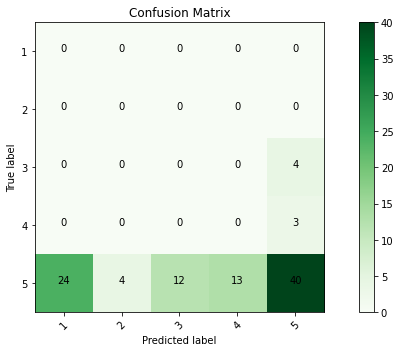

<Figure size 432x288 with 0 Axes>

In [16]:
import time
import random
import pandas as pd
from glob import glob
import pprint
import argparse
import json
import subprocess
import sys
import os
import tensorflow as tf

from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline
from transformers.configuration_distilbert import DistilBertConfig
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

CLASSES = [1, 2, 3, 4, 5]

def select_data_and_label_from_record(record):
    x = {
        'input_ids': record['input_ids'],
        'input_mask': record['input_mask'],
        'segment_ids': record['segment_ids']
    }

    y = record['label_ids']

    return (x, y)


def file_based_input_dataset_builder(channel,
                                     input_filenames,
                                     pipe_mode,
                                     is_training,
                                     drop_remainder,
                                     batch_size,
                                     epochs,
                                     steps_per_epoch,
                                     max_seq_length):

    # For training, we want a lot of parallel reading and shuffling.
    # For eval, we want no shuffling and parallel reading doesn't matter.

    if pipe_mode:
            print('***** Using pipe_mode with channel {}'.format(channel))
            from sagemaker_tensorflow import PipeModeDataset
            dataset = PipeModeDataset(channel=channel,
                                      record_format='TFRecord')
    else:
        print('***** Using input_filenames {}'.format(input_filenames))
        dataset = tf.data.TFRecordDataset(input_filenames)
    
    dataset = dataset.repeat(epochs * steps_per_epoch * 100)

    name_to_features = {
      "input_ids": tf.io.FixedLenFeature([max_seq_length], tf.int64),
      "input_mask": tf.io.FixedLenFeature([max_seq_length], tf.int64),
      "segment_ids": tf.io.FixedLenFeature([max_seq_length], tf.int64),
      "label_ids": tf.io.FixedLenFeature([], tf.int64),
    }

    def _decode_record(record, name_to_features):
        """Decodes a record to a TensorFlow example."""
        record = tf.io.parse_single_example(record, name_to_features)
        return record
    
    dataset = dataset.apply(
        tf.data.experimental.map_and_batch(
          lambda record: _decode_record(record, name_to_features),
          batch_size=batch_size,
          drop_remainder=drop_remainder,
          num_parallel_calls=tf.data.experimental.AUTOTUNE))

    dataset = dataset.shuffle(buffer_size=1000,
                              reshuffle_each_iteration=True)
    return dataset


def load_checkpoint_model(checkpoint_path):
    import glob
    import os
    
    glob_pattern = os.path.join(checkpoint_path, '*.h5')
    print('glob pattern {}'.format(glob_pattern))

    list_of_checkpoint_files = glob.glob(glob_pattern)
    print('List of checkpoint files {}'.format(list_of_checkpoint_files))
    
    latest_checkpoint_file = max(list_of_checkpoint_files)
    print('Latest checkpoint file {}'.format(latest_checkpoint_file))

    initial_epoch_number_str = latest_checkpoint_file.rsplit('_', 1)[-1].split('.h5')[0]
    initial_epoch_number = int(initial_epoch_number_str)

    loaded_model = TFDistilBertForSequenceClassification.from_pretrained(
                                               latest_checkpoint_file,
                                               config=config)

    print('loaded_model {}'.format(loaded_model))
    print('initial_epoch_number {}'.format(initial_epoch_number))
    
    return loaded_model, initial_epoch_number


if __name__ == '__main__':

    args=easydict.EasyDict({
        'train_data': train_data,
        'validation_data': validation_data,
        'test_data': test_data,
        'output_dir': output_dir,
        'local_model_dir': local_model_dir,
        'hosts': hosts,
        'current_host': current_host,
        'num_gpus': num_gpus,
        'job_name': job_name,
        'checkpoint_base_path': checkpoint_base_path,
        'use_xla': use_xla,
        'use_amp': use_amp,
        'max_seq_length': max_seq_length,
        'train_batch_size': train_batch_size,
        'validation_batch_size': validation_batch_size,
        'test_batch_size': test_batch_size,
        'epochs': epochs,
        'learning_rate': learning_rate,
        'epsilon': epsilon,
        'train_steps_per_epoch': train_steps_per_epoch,
        'validation_steps': validation_steps,
        'test_steps': test_steps,
        'freeze_bert_layer': freeze_bert_layer,
        'enable_sagemaker_debugger': enable_sagemaker_debugger,
        'run_validation': run_validation,
        'run_test': run_test,
        'run_sample_predictions': run_sample_predictions,
        'enable_tensorboard': enable_tensorboard,
        'enable_checkpointing': enable_checkpointing,
        'output_data_dir': output_data_dir,
        'is_master': is_master,
        'pipe_mode': pipe_mode
    })
    
    
    env_var = os.environ 
    print("Environment Variables:") 
    pprint.pprint(dict(env_var), width = 1) 
    
    train_data = args.train_data
    print('train_data {}'.format(train_data))
    validation_data = args.validation_data
    print('validation_data {}'.format(validation_data))
    test_data = args.test_data
    print('test_data {}'.format(test_data))    
    local_model_dir = args.local_model_dir
    print('local_model_dir {}'.format(local_model_dir))
    output_dir = args.output_dir
    print('output_dir {}'.format(output_dir))    
    hosts = args.hosts
    print('hosts {}'.format(hosts))    
    current_host = args.current_host
    print('current_host {}'.format(current_host))    
    num_gpus = args.num_gpus
    print('num_gpus {}'.format(num_gpus))
    job_name = args.job_name
    print('job_name {}'.format(job_name))    
    use_xla = args.use_xla
    print('use_xla {}'.format(use_xla))    
    use_amp = args.use_amp
    print('use_amp {}'.format(use_amp))    
    max_seq_length = args.max_seq_length
    print('max_seq_length {}'.format(max_seq_length))    
    train_batch_size = args.train_batch_size
    print('train_batch_size {}'.format(train_batch_size))    
    validation_batch_size = args.validation_batch_size
    print('validation_batch_size {}'.format(validation_batch_size))    
    test_batch_size = args.test_batch_size
    print('test_batch_size {}'.format(test_batch_size))    
    epochs = args.epochs
    print('epochs {}'.format(epochs))    
    learning_rate = args.learning_rate
    print('learning_rate {}'.format(learning_rate))    
    epsilon = args.epsilon
    print('epsilon {}'.format(epsilon))    
    train_steps_per_epoch = args.train_steps_per_epoch
    print('train_steps_per_epoch {}'.format(train_steps_per_epoch))    
    validation_steps = args.validation_steps
    print('validation_steps {}'.format(validation_steps))    
    test_steps = args.test_steps
    print('test_steps {}'.format(test_steps))    
    freeze_bert_layer = args.freeze_bert_layer
    print('freeze_bert_layer {}'.format(freeze_bert_layer))    
    enable_sagemaker_debugger = args.enable_sagemaker_debugger
    print('enable_sagemaker_debugger {}'.format(enable_sagemaker_debugger))    
    run_validation = args.run_validation
    print('run_validation {}'.format(run_validation))    
    run_test = args.run_test
    print('run_test {}'.format(run_test))    
    run_sample_predictions = args.run_sample_predictions
    print('run_sample_predictions {}'.format(run_sample_predictions))
    enable_tensorboard = args.enable_tensorboard
    print('enable_tensorboard {}'.format(enable_tensorboard))       
    enable_checkpointing = args.enable_checkpointing
    print('enable_checkpointing {}'.format(enable_checkpointing))    
    pipe_mode = args.pipe_mode
    print('pipe_mode {}'.format(pipe_mode))
    is_master = args.is_master
    print('is_master {}'.format(is_master))

    checkpoint_base_path = args.checkpoint_base_path
    print('checkpoint_base_path {}'.format(checkpoint_base_path))

    if is_master:
        checkpoint_path = checkpoint_base_path
    else:
        checkpoint_path = '/tmp/checkpoints'        
    print('checkpoint_path {}'.format(checkpoint_path))
    
    # Determine if PipeMode is enabled 
    pipe_mode_str = os.environ.get('SM_INPUT_DATA_CONFIG', '')
    pipe_mode = (pipe_mode_str.find('Pipe') >= 0)
    print('Using pipe_mode: {}'.format(pipe_mode))
 
    # Model Output 
    transformer_fine_tuned_model_path = os.path.join(local_model_dir, 'transformers/fine-tuned/')
    os.makedirs(transformer_fine_tuned_model_path, exist_ok=True)

    # SavedModel Output
    tensorflow_saved_model_path = os.path.join(local_model_dir, 'tensorflow/saved_model/0')
    os.makedirs(tensorflow_saved_model_path, exist_ok=True)

    # Tensorboard Logs 
    tensorboard_logs_path = os.path.join(local_model_dir, 'tensorboard/')
    os.makedirs(tensorboard_logs_path, exist_ok=True)  
    
    distributed_strategy = tf.distribute.MirroredStrategy()

    with distributed_strategy.scope():
        tf.config.optimizer.set_jit(use_xla)
        tf.config.optimizer.set_experimental_options({"auto_mixed_precision": use_amp})

        train_data_filenames = glob(os.path.join(train_data, '*.tfrecord'))
        print('train_data_filenames {}'.format(train_data_filenames))
        train_dataset = file_based_input_dataset_builder(
            channel='train',
            input_filenames=train_data_filenames,
            pipe_mode=pipe_mode,
            is_training=True,
            drop_remainder=False,
            batch_size=train_batch_size,
            epochs=epochs,
            steps_per_epoch=train_steps_per_epoch,
            max_seq_length=max_seq_length).map(select_data_and_label_from_record)

        tokenizer = None
        config = None
        model = None

        successful_download = False
        retries = 0
        while (retries < 5 and not successful_download):
            try:
                tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
                config = DistilBertConfig.from_pretrained('distilbert-base-uncased',
                                                          num_labels=len(CLASSES))
                model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',
                                                                              config=config)
                successful_download = True
                print('Sucessfully downloaded after {} retries.'.format(retries))
            except:
                retries = retries + 1
                random_sleep = random.randint(1, 30)
                print('Retry #{}.  Sleeping for {} seconds'.format(retries, random_sleep))
                time.sleep(random_sleep)

        callbacks = []

        initial_epoch_number = 0 

        if enable_checkpointing:
            print('***** Checkpoint enabled *****')
            
            os.makedirs(checkpoint_path, exist_ok=True)        
            if os.listdir(checkpoint_path):
                print('***** Found checkpoint *****')
                print(checkpoint_path)
                model, initial_epoch_number = load_checkpoint_model(checkpoint_path)
                print('***** Using checkpoint model {} *****'.format(model))
                
            checkpoint_callback = ModelCheckpoint(
                    filepath=os.path.join(checkpoint_path, 'tf_model_{epoch:05d}.h5'),
                    save_weights_only=False,
                    verbose=1,
                    monitor='val_accuracy')
            print('*** CHECKPOINT CALLBACK {} ***'.format(checkpoint_callback))
            callbacks.append(checkpoint_callback)

        if not tokenizer or not model or not config:
            print('Not properly initialized...')

        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon)
        print('** use_amp {}'.format(use_amp))        
        if use_amp:
            # loss scaling is currently required when using mixed precision
            optimizer = tf.keras.mixed_precision.experimental.LossScaleOptimizer(optimizer, 'dynamic')

        print('enable_sagemaker_debugger {}'.format(enable_sagemaker_debugger))
        if enable_sagemaker_debugger:
            print('*** DEBUGGING ***')
            import smdebug.tensorflow as smd
            # This assumes that we specified debugger_hook_config
            debugger_callback = smd.KerasHook.create_from_json_file()
            print('*** DEBUGGER CALLBACK {} ***'.format(debugger_callback))            
            callbacks.append(debugger_callback)
            optimizer = debugger_callback.wrap_optimizer(optimizer)

        if enable_tensorboard:            
            tensorboard_callback = tf.keras.callbacks.TensorBoard(
                                                        log_dir=tensorboard_logs_path)
            print('*** TENSORBOARD CALLBACK {} ***'.format(tensorboard_callback))
            callbacks.append(tensorboard_callback)
  
        print('*** OPTIMIZER {} ***'.format(optimizer))
        
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

        model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
        print('Compiled model {}'.format(model))          
        model.layers[0].trainable = not freeze_bert_layer
        print(model.summary())

        if run_validation:
            validation_data_filenames = glob(os.path.join(validation_data, '*.tfrecord'))
            print('validation_data_filenames {}'.format(validation_data_filenames))
            validation_dataset = file_based_input_dataset_builder(
                channel='validation',
                input_filenames=validation_data_filenames,
                pipe_mode=pipe_mode,
                is_training=False,
                drop_remainder=False,
                batch_size=validation_batch_size,
                epochs=epochs,
                steps_per_epoch=validation_steps,
                max_seq_length=max_seq_length).map(select_data_and_label_from_record)
            
            print('Starting Training and Validation...')
            validation_dataset = validation_dataset.take(validation_steps)
            train_and_validation_history = model.fit(train_dataset,
                                                     shuffle=True,
                                                     epochs=epochs,
                                                     initial_epoch=initial_epoch_number,
                                                     steps_per_epoch=train_steps_per_epoch,
                                                     validation_data=validation_dataset,
                                                     validation_steps=validation_steps,
                                                     callbacks=callbacks)                                
            print(train_and_validation_history)
        else: # Not running validation
            print('Starting Training (Without Validation)...')
            train_history = model.fit(train_dataset,
                                      shuffle=True,
                                      epochs=epochs,
                                      initial_epoch=initial_epoch_number,
                                      steps_per_epoch=train_steps_per_epoch,
                                      callbacks=callbacks)                
            print(train_history)

        if run_test:
            test_data_filenames = glob(os.path.join(test_data, '*.tfrecord'))
            print('test_data_filenames {}'.format(test_data_filenames))
            test_dataset = file_based_input_dataset_builder(
                channel='test',
                input_filenames=test_data_filenames,
                pipe_mode=pipe_mode,
                is_training=False,
                drop_remainder=False,
                batch_size=test_batch_size,
                epochs=epochs,
                steps_per_epoch=test_steps,
                max_seq_length=max_seq_length).map(select_data_and_label_from_record)

            print('Starting test...')
            test_history = model.evaluate(test_dataset,
                                          steps=test_steps,
                                          callbacks=callbacks)
                                 
            print('Test history {}'.format(test_history))
            
        # Save the Fine-Tuned Transformers Model as a New "Pre-Trained" Model
        print('transformer_fine_tuned_model_path {}'.format(transformer_fine_tuned_model_path))   
        model.save_pretrained(transformer_fine_tuned_model_path)

        # Save the TensorFlow SavedModel for Serving Predictions
        print('tensorflow_saved_model_path {}'.format(tensorflow_saved_model_path))   
        model.save(tensorflow_saved_model_path, save_format='tf')
                
        # Copy inference.py and requirements.txt to the code/ directory
        #   Note: This is required for the SageMaker Endpoint to pick them up.
        #         This appears to be hard-coded and must be called code/
        inference_path = os.path.join(local_model_dir, 'code/')
        # print('Copying inference source files to {}'.format(inference_path))
        os.makedirs(inference_path, exist_ok=True)               
        os.system('cp inference.py {}'.format(inference_path))
        print(glob(inference_path))        
#        os.system('cp requirements.txt {}/code'.format(inference_path))
        
    if run_sample_predictions:
        loaded_model = TFDistilBertForSequenceClassification.from_pretrained(transformer_fine_tuned_model_path,
                                                                       id2label={
                                                                        0: 1,
                                                                        1: 2,
                                                                        2: 3,
                                                                        3: 4,
                                                                        4: 5
                                                                       },
                                                                       label2id={
                                                                        1: 0,
                                                                        2: 1,
                                                                        3: 2,
                                                                        4: 3,
                                                                        5: 4
                                                                       })

        tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

        if num_gpus >= 1:
            inference_device = 0 # GPU 0
        else:
            inference_device = -1 # CPU
        print('inference_device {}'.format(inference_device))

        inference_pipeline = TextClassificationPipeline(model=loaded_model, 
                                                        tokenizer=tokenizer,
                                                        framework='tf',
                                                        device=inference_device)  

        print("""I loved it!  I will recommend this to everyone.""", inference_pipeline("""I loved it!  I will recommend this to everyone."""))
        print("""It's OK.""", inference_pipeline("""It's OK."""))
        print("""Really bad.  I hope they don't make this anymore.""", inference_pipeline("""Really bad.  I hope they don't make this anymore."""))

        import csv

        df_test_reviews = pd.read_csv('./test_data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz', 
                                        delimiter='\t', 
                                        quoting=csv.QUOTE_NONE,
                                        compression='gzip')[['review_body', 'star_rating']]

        df_test_reviews = df_test_reviews.sample(n=100)
        df_test_reviews.shape
        df_test_reviews.head()
        
        import pandas as pd

        def predict(review_body):
            prediction_map = inference_pipeline(review_body)
            return prediction_map[0]['label']

        y_test = df_test_reviews['review_body'].map(predict)
        y_test
        
        y_actual = df_test_reviews['star_rating']
        y_actual

        from sklearn.metrics import classification_report
        print(classification_report(y_true=y_test, y_pred=y_actual))
        
        from sklearn.metrics import accuracy_score
        print('Accuracy: ', accuracy_score(y_true=y_test, y_pred=y_actual))
        
        import matplotlib.pyplot as plt
        import pandas as pd

        def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
            print(cm)
            plt.imshow(cm, interpolation='nearest', cmap=cmap)
            plt.title(title)
            plt.colorbar()
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes, rotation=45)
            plt.yticks(tick_marks, classes)

            fmt = 'd'
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="black" if cm[i, j] > thresh else "black")

                plt.tight_layout()
                plt.ylabel('True label')
                plt.xlabel('Predicted label')
                
        import itertools
        import numpy as np
        from sklearn.metrics import confusion_matrix
        import matplotlib.pyplot as plt
        #%matplotlib inline
        #%config InlineBackend.figure_format='retina'

        cm = confusion_matrix(y_true=y_test, y_pred=y_actual)

        plt.figure()
        fig, ax = plt.subplots(figsize=(10,5))
        plot_conf_mat(cm, 
                      classes=['1', '2', '3', '4', '5'], 
                      title='Confusion Matrix')

        # Save the confusion matrix        
        plt.show()
        
        # Model Output 
        metrics_path = os.path.join(local_model_dir, 'metrics/')
        os.makedirs(metrics_path, exist_ok=True)
        plt.savefig('{}/confusion_matrix.png'.format(metrics_path))
